In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import PowerTransformer

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline as SkPipeline

In [29]:
DATA_DIR = "datasets/"
MODULE = "BBB"
PRESENTATIONS = ["2013B", "2013J"]
TIME_CHECKPOINTS = [14, 30, 60, 90, 120, 150, 180, 210]

# window ngắn hạn để bắt “dấu hiệu gần đây”
WINDOW_DAYS = 14
HALF_WINDOW = 7

student_info = pd.read_csv(DATA_DIR + "studentInfo.csv")
student_reg  = pd.read_csv(DATA_DIR + "studentRegistration.csv")
student_vle  = pd.read_csv(DATA_DIR + "studentVle.csv")
student_ass  = pd.read_csv(DATA_DIR + "studentAssessment.csv")

print(f"--- {MODULE} {PRESENTATIONS} ---")
print(f"TIME CHECKPOINTS: {TIME_CHECKPOINTS}, WINDOW={WINDOW_DAYS} days")


--- BBB ['2013B', '2013J'] ---
TIME CHECKPOINTS: [14, 30, 60, 90, 120, 150, 180, 210], WINDOW=14 days


In [30]:
reg_filtered = student_reg[
    (student_reg["code_module"] == MODULE)
    & (student_reg["code_presentation"].isin(PRESENTATIONS))
    & (student_reg["date_registration"] <= 0)
]
valid_ids = reg_filtered["id_student"].unique()

students = student_info[
    (student_info["code_module"] == MODULE)
    & (student_info["code_presentation"].isin(PRESENTATIONS))
    & (student_info["id_student"].isin(valid_ids))
].copy()

students["dropout"] = (students["final_result"] == "Withdrawn").astype(int)
print("Unique students:", students["id_student"].nunique())

# =========================
# helper: inactivity streak within [start,end]
# =========================
def compute_inactivity_streak(days_list, start_day, end_day):
    if not days_list:
        return end_day - start_day + 1
    active_set = set(days_list)
    streak = 0
    d = end_day
    while d >= start_day and d not in active_set:
        streak += 1
        d -= 1
    return streak

Unique students: 3931


In [31]:
# =========================
# 2) Build time-aware snapshots with extra features
# =========================
assessments = pd.read_csv(f"{DATA_DIR}assessments.csv")
target_assessment_ids = assessments.loc[
    (assessments["code_module"] == MODULE)
    & (assessments["code_presentation"].isin(PRESENTATIONS)),
    "id_assessment"
].unique()

augmented = []

for cutoff in TIME_CHECKPOINTS:
    w_start = max(0, cutoff - (WINDOW_DAYS - 1))
    w_end   = cutoff
    w_mid   = max(w_start, w_end - (HALF_WINDOW - 1))  # last 7 days start

    # ---- VLE cumulative up to cutoff
    vle_cum = student_vle[
        (student_vle["code_module"] == MODULE)
        & (student_vle["code_presentation"].isin(PRESENTATIONS))
        & (student_vle["id_student"].isin(students["id_student"]))
        & (student_vle["date"] <= cutoff)
    ].copy()

    # ---- VLE sliding window (last 14 days)
    vle_win = vle_cum[vle_cum["date"] >= w_start].copy()

    # cumulative aggregation
    cum_agg = (vle_cum.groupby("id_student")
               .agg(total_clicks=("sum_click","sum"),
                    active_days_total=("date","nunique"),
                    last_active=("date","max"))
               .reset_index())

    cum_agg["days_elapsed_program"] = cutoff
    cum_agg["clicks_per_day_total"] = cum_agg["total_clicks"] / max(cutoff, 1)
    cum_agg["active_ratio_total"]   = cum_agg["active_days_total"] / max(cutoff, 1)
    cum_agg["days_since_last_active"] = cutoff - cum_agg["last_active"]
    cum_agg["avg_clicks_per_active_day_total"] = (
        cum_agg["total_clicks"] / cum_agg["active_days_total"].replace(0, np.nan)
    ).fillna(0)

    # sliding window aggregation (14d)
    win_agg = (vle_win.groupby("id_student")
               .agg(clicks_last_14_days=("sum_click","sum"),
                    active_days_14=("date","nunique"))
               .reset_index())
    win_agg["clicks_per_day_14"] = win_agg["clicks_last_14_days"] / WINDOW_DAYS
    win_agg["active_ratio_14"]   = win_agg["active_days_14"] / WINDOW_DAYS

    # 0-7 vs 8-14 inside the 14-day window (trend)
    # define split: first half = [w_start, w_start+6], second half = [w_start+7, w_end]
    first_end = min(w_end, w_start + (HALF_WINDOW - 1))
    second_start = min(w_end, first_end + 1)

    clicks_0_7 = (vle_win[(vle_win["date"] >= w_start) & (vle_win["date"] <= first_end)]
                  .groupby("id_student")["sum_click"].sum()
                  .reset_index(name="clicks_0_7"))
    clicks_8_14 = (vle_win[(vle_win["date"] >= second_start) & (vle_win["date"] <= w_end)]
                   .groupby("id_student")["sum_click"].sum()
                   .reset_index(name="clicks_8_14"))

    # last 7 days clicks (more “real-time”)
    clicks_last_7 = (vle_cum[vle_cum["date"] > (cutoff - 7)]
                     .groupby("id_student")["sum_click"].sum()
                     .reset_index(name="clicks_last_7_days"))

    # inactivity streak within window
    days_list = (vle_win.groupby("id_student")["date"]
                 .apply(lambda x: sorted(x.unique()))
                 .reset_index()
                 .rename(columns={"date": "active_days_list"}))
    days_list["inactivity_streak_14"] = days_list["active_days_list"].apply(
        lambda lst: compute_inactivity_streak(lst, w_start, w_end)
    )
    streak = days_list[["id_student", "inactivity_streak_14"]]

    # ---- Assessment cumulative up to cutoff (FIX leakage module/presentation)
    ass_cum = student_ass[
        (student_ass["id_assessment"].isin(target_assessment_ids)) & # <--- SỬA DÒNG NÀY
        (student_ass["id_student"].isin(students["id_student"])) &
        (student_ass["date_submitted"].notna()) &
        (student_ass["date_submitted"] <= cutoff)
    ].copy()

    ass_agg = (ass_cum.groupby("id_student")
               .agg(num_assessments=("id_assessment","nunique"),
                    avg_score=("score","mean"),
                    pass_count=("score", lambda x: (x >= 40).sum()),
                    last_score=("score","last"))
               .reset_index())

    # assessment in last 14 days
    ass_win = ass_cum[ass_cum["date_submitted"] >= w_start]
    ass_agg_14 = (ass_win.groupby("id_student")
                  .agg(num_assessments_14=("id_assessment","nunique"),
                       avg_score_14=("score","mean"))
                  .reset_index())

    # ---- merge all
    base = students[["id_student", "dropout"]].copy()
    merged = base.merge(cum_agg, on="id_student", how="left")
    merged = merged.merge(win_agg, on="id_student", how="left")
    merged = merged.merge(clicks_0_7, on="id_student", how="left")
    merged = merged.merge(clicks_8_14, on="id_student", how="left")
    merged = merged.merge(clicks_last_7, on="id_student", how="left")
    merged = merged.merge(streak, on="id_student", how="left")
    merged = merged.merge(ass_agg, on="id_student", how="left")
    merged = merged.merge(ass_agg_14, on="id_student", how="left")

    # fillna
    fill0 = [
        "total_clicks","active_days_total","last_active",
        "clicks_last_14_days","active_days_14",
        "clicks_0_7","clicks_8_14","clicks_last_7_days",
        "inactivity_streak_14",
        "num_assessments","avg_score","pass_count","last_score",
        "num_assessments_14","avg_score_14"
    ]
    for c in fill0:
        merged[c] = merged[c].fillna(0)

    # derived trend/ratios (add +1 to avoid /0)
    merged["trend_click_14"] = merged["clicks_8_14"] - merged["clicks_0_7"]
    merged["ratio_click_14"] = (merged["clicks_8_14"] + 1) / (merged["clicks_0_7"] + 1)

    # re-assert context
    merged["days_elapsed_program"] = cutoff

    augmented.append(merged)

final_df = pd.concat(augmented, ignore_index=True)
print("Augmented shape:", final_df.shape)

Augmented shape: (31800, 26)


In [32]:

# =========================
# Feature list (numeric only, production-friendly)
# =========================
feature_cols = [
    # context
    "days_elapsed_program",

    # cumulative
    # "total_clicks",
    # "active_days_total",
    "clicks_per_day_total",
    "active_ratio_total",
    "avg_clicks_per_active_day_total",
    "days_since_last_active",

    # sliding window 14d
    "clicks_last_14_days",
    "active_days_14",
    "clicks_per_day_14",
    "active_ratio_14",
    "clicks_last_7_days",

    # trend/streak
    "clicks_0_7",
    "clicks_8_14",
    "trend_click_14",
    "ratio_click_14",
    "inactivity_streak_14",

    # assessment
    "num_assessments",
    "avg_score",
    "pass_count",
    "last_score",
    "num_assessments_14",
    "avg_score_14",
]

X = final_df[feature_cols]
y = final_df["dropout"].astype(int)
groups = final_df["id_student"]

X = X.fillna(0)
print("NaN count in X:", X.isna().sum().sum())

print("Num features:", len(feature_cols))

NaN count in X: 0
Num features: 21


In [33]:
MODELS = {
    "GradientBoostingClassifier": GradientBoostingClassifier(
        learning_rate=0.03,
        loss="exponential",
        max_depth=3,
        min_samples_leaf=40,
        min_samples_split=20,
        n_estimators=10,
        n_iter_no_change=10,
        random_state=42
    ),
    "RandomForestClassifier": RandomForestClassifier(
        criterion="gini",
        max_depth=3,
        min_samples_leaf=10,
        min_samples_split=50,
        n_estimators=50,
        random_state=42,
        n_jobs=-1
    ),
    "MLPClassifier": MLPClassifier(
        alpha=0.1,
        early_stopping=True,
        hidden_layer_sizes=(135,),
        learning_rate="constant",
        learning_rate_init=0.3,
        max_iter=1200,
        momentum=0.9,
        solver="sgd",
        random_state=42
    ),
    "LogisticRegression": LogisticRegression(
        penalty="l1",
        solver="saga",
        tol=1e-4,
        max_iter=2000,
        random_state=42
    )
}


In [34]:

VAR_THRESH = 0.0  # production-safe; 3 can drop too many columns with small feature set

def make_eval_pipe(model):
    # Like notebook: VarianceThreshold + SMOTE + PowerTransformer + classifier
    return ImbPipeline([
        ("variance_threshold", VarianceThreshold(VAR_THRESH)),
        ("smote", SMOTE()),
        ("power_transformer", PowerTransformer()),
        ("classifier", model),
    ])

def make_prod_pipe(model):
    # Production: NO SMOTE
    return SkPipeline([
        ("variance_threshold", VarianceThreshold(VAR_THRESH)),
        ("power_transformer", PowerTransformer()),
        ("classifier", model),
    ])

# =========================
# GroupKFold evaluation + ROC curves
# =========================
gkf = GroupKFold(n_splits=5)
mean_fpr = np.linspace(0, 1, 200)

summary_rows = []
roc_by_model = {}

for name, model in MODELS.items():
    rows = []
    tprs = []

    for fold, (tr_idx, te_idx) in enumerate(gkf.split(X, y, groups), start=1):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        pipe = make_eval_pipe(model)
        pipe.fit(X_tr, y_tr)

        y_pred = pipe.predict(X_te)
        y_proba = pipe.predict_proba(X_te)[:, 1]

        acc = accuracy_score(y_te, y_pred)
        f1  = f1_score(y_te, y_pred)
        sens = recall_score(y_te, y_pred)
        spec = recall_score(y_te, y_pred, pos_label=0)
        auc = roc_auc_score(y_te, y_proba)

        rows.append({"model": name, "fold": fold, "accuracy": acc, "f1": f1, "sensitivity": sens, "specificity": spec, "auc": auc})

        fpr, tpr, _ = roc_curve(y_te, y_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

    df = pd.DataFrame(rows)
    summary_rows.append({
        "model": name,
        "mean_accuracy": df["accuracy"].mean(),
        "mean_f1": df["f1"].mean(),
        "mean_sensitivity": df["sensitivity"].mean(),
        "mean_specificity": df["specificity"].mean(),
        "mean_auc": df["auc"].mean(),
    })

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    roc_by_model[name] = mean_tpr

summary_df = pd.DataFrame(summary_rows).sort_values("mean_f1", ascending=False)
display(summary_df)

best_model_name = summary_df.iloc[0]["model"]
print("Best model by mean F1:", best_model_name)


/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of

,model,mean_accuracy,mean_f1,mean_sensitivity,mean_specificity,mean_auc
2,MLPClassifier,0.820660,0.711414,0.769878,0.841211,0.867172
0,GradientBoostingClassifier,0.816321,0.702687,0.756077,0.840602,0.862261
3,LogisticRegression,0.813522,0.700958,0.762070,0.834367,0.860029
1,RandomForestClassifier,0.811101,0.698711,0.762803,0.830747,0.864045


Best model by mean F1: MLPClassifier


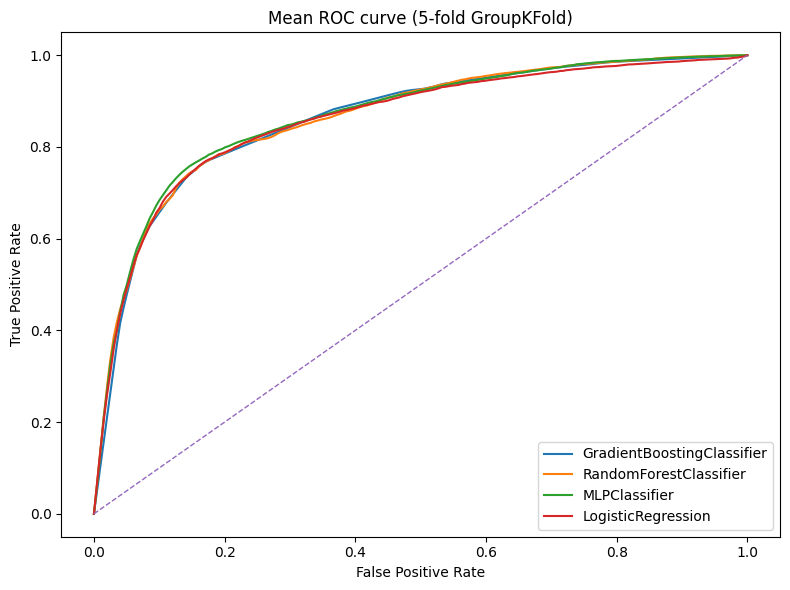

In [35]:

# =========================
# Plot ROC curves (mean across folds)
# =========================
plt.figure(figsize=(8, 6))
for name, mean_tpr in roc_by_model.items():
    plt.plot(mean_fpr, mean_tpr, label=name)
plt.plot([0,1], [0,1], linestyle="--", linewidth=1)
plt.title("Mean ROC curve (5-fold GroupKFold)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

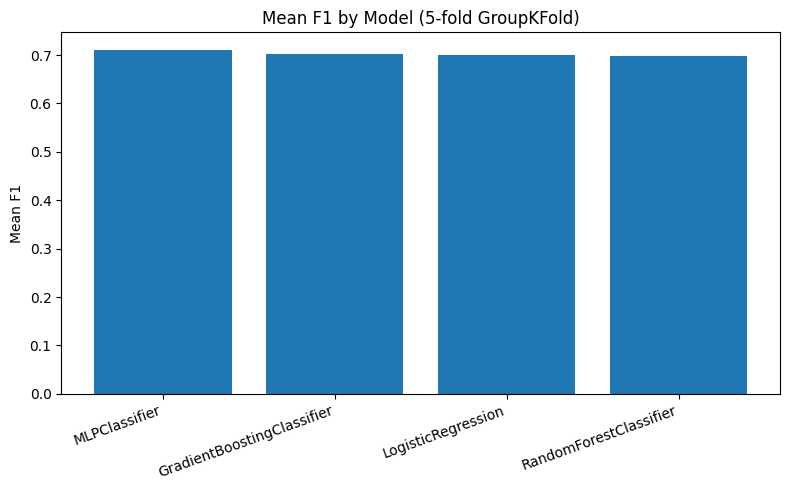

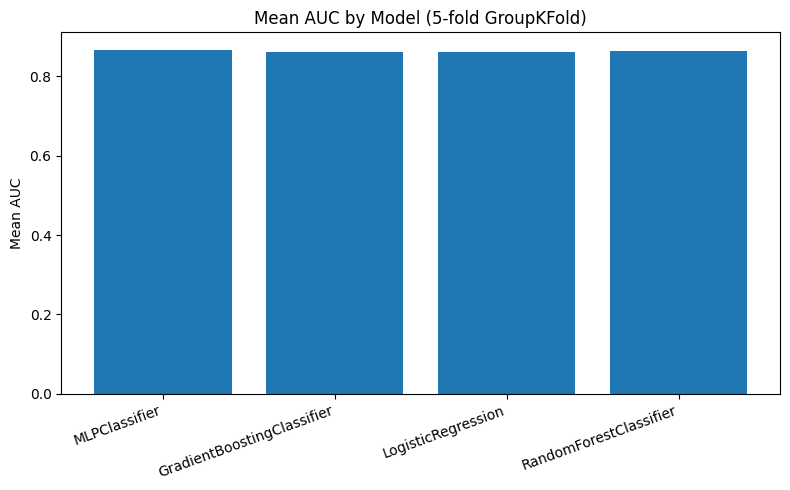

In [36]:

# =========================
# Bar chart for mean F1 and mean AUC
# =========================
plt.figure(figsize=(8, 5))
plt.bar(summary_df["model"], summary_df["mean_f1"])
plt.title("Mean F1 by Model (5-fold GroupKFold)")
plt.ylabel("Mean F1")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(summary_df["model"], summary_df["mean_auc"])
plt.title("Mean AUC by Model (5-fold GroupKFold)")
plt.ylabel("Mean AUC")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

In [39]:
# =========================
# 9) Train Final Model & Save (CHẠY LẠI ĐỂ TẠO final_pipeline)
# =========================
import joblib


print("\n--- ĐANG HUẤN LUYỆN MODEL CUỐI CÙNG ---")

# Lấy model tốt nhất từ bước đánh giá trước đó (hoặc mặc định là RandomForest)
# Nếu bạn chưa chạy vòng lặp đánh giá, ta khởi tạo cứng RandomForest ở đây cho chắc chắn:
final_model = LogisticRegression(
        penalty="l1",
        solver="saga",
        tol=1e-4,
        max_iter=2000,
        random_state=42
    )
# Tạo Pipeline sản phẩm (Product Pipeline - Không dùng SMOTE)
final_pipeline = SkPipeline([
    ("variance_threshold", VarianceThreshold(0.0)),
    ("power_transformer", PowerTransformer()),
    ("classifier", final_model),
])

# Huấn luyện
final_pipeline.fit(X, y)
print("Huấn luyện xong!")

# Lưu model ra file
model_filename = "dropout_model_time_aware.pkl"
joblib.dump(final_pipeline, model_filename)
print(f"Đã lưu model vào: {model_filename}")


# =========================
# 11) Analyze & Visualize Feature Importance (%)
# =========================
print("\n--- PHÂN TÍCH ĐỘ QUAN TRỌNG CỦA CÁC THUỘC TÍNH ---")

# 1. Lấy ra classifier từ pipeline
classifier = final_pipeline.named_steps['classifier']

# 2. Kiểm tra và vẽ biểu đồ
if hasattr(classifier, 'feature_importances_'):
    importances = classifier.feature_importances_
    
    # Lấy tên cột sau khi qua VarianceThreshold (nếu có cột bị loại)
    # Tuy nhiên với threshold=0 và data này thường giữ nguyên
    # Ta dùng lại feature_cols ban đầu
    if len(importances) != len(feature_cols):
        print("Cảnh báo: Số lượng feature không khớp (có thể do VarianceThreshold).")
        # Trong trường hợp này ta lấy index để map tạm
        feat_names = [f"Feature {i}" for i in range(len(importances))]
    else:
        feat_names = feature_cols

    fi_df = pd.DataFrame({
        "feature": feat_names,
        "importance": importances
    })
    
    # Tính phần trăm
    fi_df["importance_percent"] = fi_df["importance"] * 100
    fi_df = fi_df.sort_values("importance_percent", ascending=True)

    # In ra top 10 quan trọng nhất
    print(fi_df.sort_values("importance_percent", ascending=False).head(10))

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 8))
    # Tô màu: Top 5 màu xanh, còn lại màu xám
    colors = ['#e0e0e0'] * (len(fi_df) - 5) + ['#2ca02c'] * 5
    
    bars = plt.barh(fi_df["feature"], fi_df["importance_percent"], color=colors)
    plt.xlabel("Mức độ ảnh hưởng (%)")
    plt.title("Tầm quan trọng của các thuộc tính (Random Forest Time-Aware)")
    
    # Hiển thị số % trên thanh
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                 f'{width:.1f}%', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()
else:
    print("Model này không hỗ trợ Feature Importance.")


--- ĐANG HUẤN LUYỆN MODEL CUỐI CÙNG ---


/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Huấn luyện xong!
Đã lưu model vào: dropout_model_time_aware.pkl

--- PHÂN TÍCH ĐỘ QUAN TRỌNG CỦA CÁC THUỘC TÍNH ---
Model này không hỗ trợ Feature Importance.


In [38]:

# =========================
# Train FINAL production model (NO SMOTE) for cron inference
# =========================
best_model = MODELS[best_model_name]
final_pipeline = make_prod_pipe(best_model)
final_pipeline.fit(X, y)

# Simple production threshold
# (Bạn có thể hạ 0.5 xuống 0.35 nếu muốn nhạy hơn cảnh báo)
PROD_THRESHOLD = 0.5

def predict_dropout_risk(feature_row_df: pd.DataFrame) -> dict:
    proba = float(final_pipeline.predict_proba(feature_row_df)[0, 1])
    label = int(proba >= PROD_THRESHOLD)
    return {"risk_prob": proba, "risk_label": label, "threshold": PROD_THRESHOLD}

# Example for cron
sample = pd.DataFrame([{
    # context
    "days_elapsed_program": 45,

    # cumulative
    "total_clicks": 120,
    "active_days_total": 10,
    "clicks_per_day_total": 120/45,
    "active_ratio_total": 10/45,
    "avg_clicks_per_active_day_total": 120/10,
    "days_since_last_active": 5,

    # 14d window
    "clicks_last_14_days": 15,
    "active_days_14": 3,
    "clicks_per_day_14": 15/14,
    "active_ratio_14": 3/14,
    "clicks_last_7_days": 2,

    # trend
    "clicks_0_7": 13,
    "clicks_8_14": 2,
    "trend_click_14": 2 - 13,
    "ratio_click_14": (2+1)/(13+1),
    "inactivity_streak_14": 5,

    # assessment
    "num_assessments": 1,
    "avg_score": 80,
    "pass_count": 1,
    "last_score": 80,
    "num_assessments_14": 1,
    "avg_score_14": 80,
}])

print("Cron simulation:", predict_dropout_risk(sample))


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- active_days_total
- total_clicks
